In [103]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import copy
import select
from skimage import feature as ft

from sklearn.utils import shuffle


importpath   = "../../../Dataset/"
testrainpath = ["Testing", "Training"]
namespath    = ["/Abed/", "/Daniel/", "/Jules/", "/Lea/", "/Patrick/"]
rescaledpath = "Rescaled"
croppedpath  = "Cropped"

meta_data = {0: 'Abed', 1: 'Daniel', 2: 'Jules', 3: 'Lea', 4: 'Patrick'}

def get_data(isCropped=True):

    # Test train data
    X_train = []
    Y_train = []

    X_test  = []
    Y_test  = []

    # define both import paths
    testpath = importpath+testrainpath[0]
    trainpath= importpath+testrainpath[1]

    for i, npath in enumerate(namespath):

        if isCropped:
            testfolder = testpath + croppedpath + npath
            trainfolder= trainpath+ croppedpath + npath
        else:
            testfolder = testpath + rescaledpath + npath
            trainfolder= trainpath+ rescaledpath + npath

        for imgname in os.listdir(testfolder):

            img = cv2.imread(testfolder+imgname)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            X_test.append(img)
            Y_test.append(i)

        for imgname2 in os.listdir(trainfolder):

            img = cv2.imread(trainfolder+imgname2)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            X_train.append(img)
            Y_train.append(i)

#     # once the data is saved, shuffle it
#     X_train , Y_train = shuffle(X_train, Y_train)
#     X_test  , Y_test  = shuffle(X_test, Y_test)

    return np.asarray(X_train), np.asarray(Y_train), np.asarray(X_test), np.asarray(Y_test), meta_data

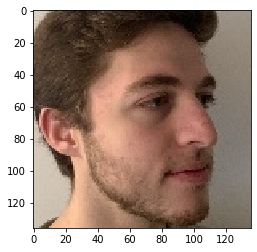

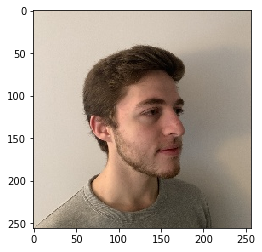

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import copy
import matplotlib.pyplot as plt


def sift(img):

    # copy image
    img_disp = img.copy()
    # convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)

    # create a SIFT object
    sift = cv2.xfeatures2d.SIFT_create()

    # detect SIFT features, with no masks
    keypoints = sift.detect(img, None)
    
    p = []
    keypoints3, descriptors = sift.compute(img, keypoints)
    for k in keypoints3:
        p.append(k.pt)

    # draw the keypoints
    cv2.drawKeypoints(img, keypoints, img_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#     display
    plt.figure(figsize=(10, 10))
    plt.subplot(121), plt.imshow(img)
    plt.title("Input Image"), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(img_disp)
    plt.title("SIFT Features"), plt.xticks([]), plt.yticks([])
    plt.show()

    # num of SIFT keypoints
    print('Num keypoints: ' + str(len(keypoints)))

    return p


import cv2
# Get croppped image coordinates in original image (x,y in top left corner)
def get_coordinates(img_rescaled, img_cropped):
    # imgggg_rgb = cv2.imread("../../../Dataset/TrainingRescaled/Abed/scale1_0.jpeg")
    # img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    # template = cv2.imread("../../../Dataset/TrainingCropped/Abed/scale1_0.jpeg", 0)
    img_rescaled = cv2.cvtColor(img_rescaled, cv2.COLOR_BGR2GRAY)
    img_cropped = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
    w, h = img_cropped.shape[::-1]
    res = cv2.matchTemplate(img_rescaled, img_cropped, cv2.TM_SQDIFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = min_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    x = top_left[0]
    y = top_left[1]
    return x, y


def make_patch(img,img_cropped, size, k):
    # get patch centers
    patch_centers = []
    for i in k:
        patch_centers.append(i)

    # extract patches
    patch_images = []
    patch_size = size
    count=0
    for center in patch_centers:
        patchXStart = int(center[0] - (patch_size / 2.))
        patchYStart = int(center[1] - (patch_size / 2.))
        if((center[0] + patch_size)>img_cropped.shape[1] or (center[0] - patch_size)<0 or (center[1] + patch_size)>img_cropped.shape[0] or (center[1] - patch_size)<0 ):
            count+=1
            x,y = get_coordinates(img, img_cropped)
            patchXStart += x
            patchYStart += y
            patch_images.append(img[patchXStart:patchXStart + patch_size, patchYStart:patchYStart + patch_size])
        else:
            patch_images.append(img_cropped[patchXStart:patchXStart + patch_size, patchYStart:patchYStart + patch_size])

    print("count= " , count)
#     # display
#     for im in patch_images:
#         plt.figure(figsize=(5, 5))
#         plt.imshow(im)
#         plt.title("Input Image"), plt.xticks([]), plt.yticks([])
#         plt.show()
    return patch_images


# ----- HoG Function ----- #
def rgb2gray(im):
    gray = im[:, :, 0] * 0.2989 + im[:, :, 1] * 0.5870 + im[:, :, 2] * 0.1140
    return gray

def hog_features(imgs, cells):
    print(np.shape(imgs))
    train_x = []
    for data in imgs:
        gray = rgb2gray(data) / 255.0
        x = ft.hog(gray, orientations=9, pixels_per_cell=(2, 2),
                   cells_per_block=(cells, cells))
        train_x.append(x)
        print(np.shape(train_x))
    return train_x



if __name__ == '__main__':

   # Read in data
    cropped_data = get_data(isCropped=True)
    X_train_cropped = cropped_data[0]
    Y_train_cropped = cropped_data[1]
    X_test_cropped = cropped_data[2]
    Y_test_cropped = cropped_data[3]
    metadata_cropped = cropped_data[4]
    
    data = get_data(isCropped=False)
    X_train = data[0]
    Y_train = data[1]
    X_test = data[2]
    Y_test = data[3]
    metadata = data[4]

    plt.imshow(X_train_cropped[0])
    plt.show()
    

    plt.imshow(X_train[0]) 
    plt.show()




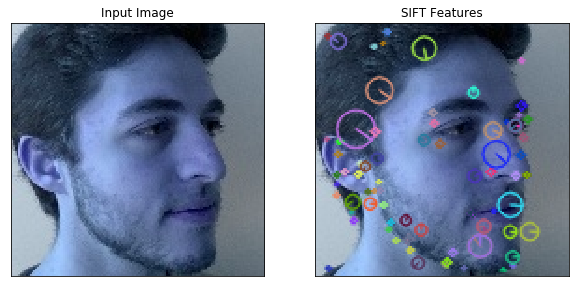

Num keypoints: 86
count=  10
(15, 15, 15, 3)


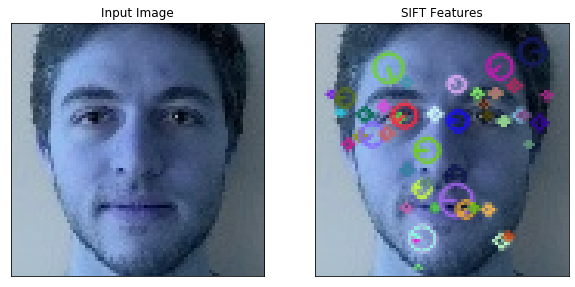

Num keypoints: 50
count=  6
(15, 15, 15, 3)


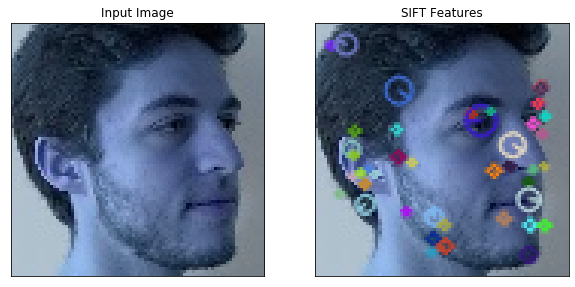

Num keypoints: 47
count=  9
(15, 15, 15, 3)


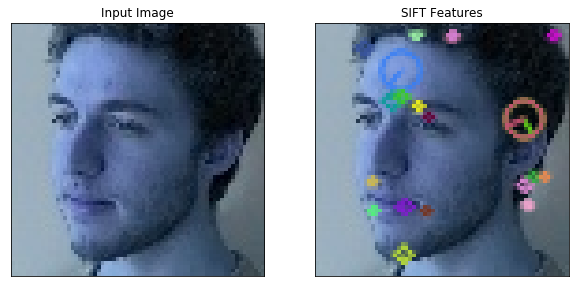

Num keypoints: 22
count=  6
(15, 15, 15, 3)


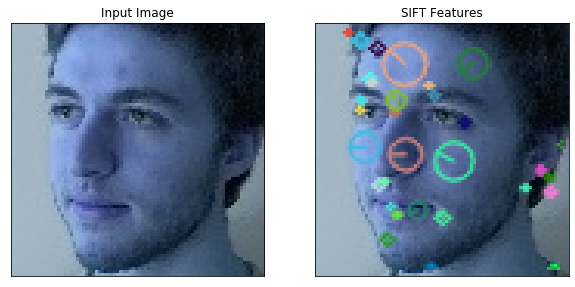

Num keypoints: 34
count=  9
(15, 15, 15, 3)


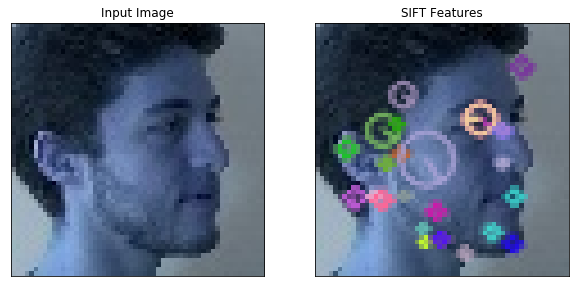

Num keypoints: 27
count=  9
(15, 15, 15, 3)


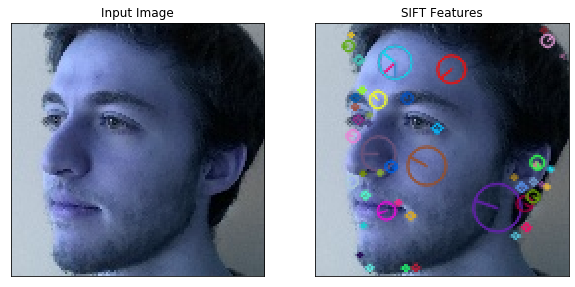

Num keypoints: 50
count=  3
(15, 15, 15, 3)


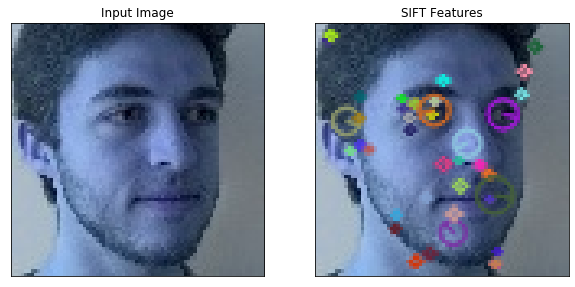

Num keypoints: 45
count=  7
(15, 15, 15, 3)


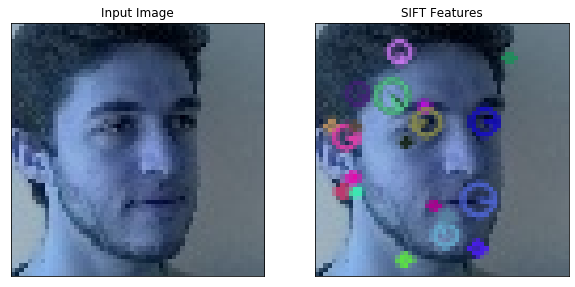

Num keypoints: 22
count=  10
(15, 15, 15, 3)


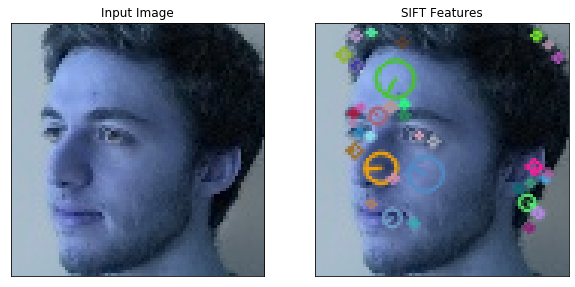

Num keypoints: 38
count=  11
(15, 15, 15, 3)


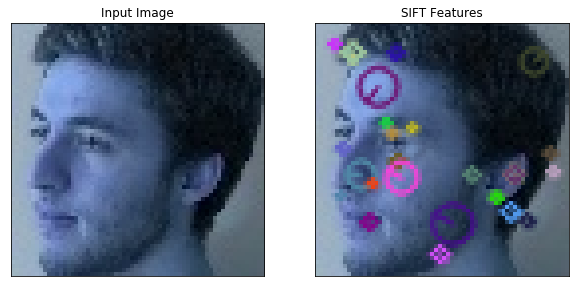

Num keypoints: 27
count=  9
(15, 15, 15, 3)


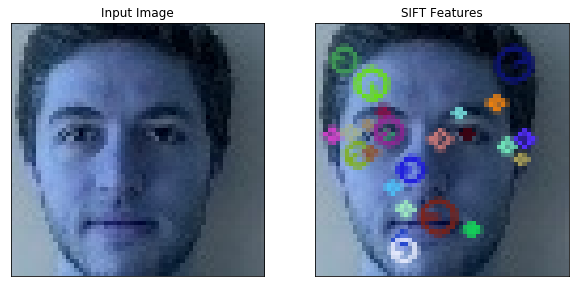

Num keypoints: 25
count=  9
(15, 15, 15, 3)


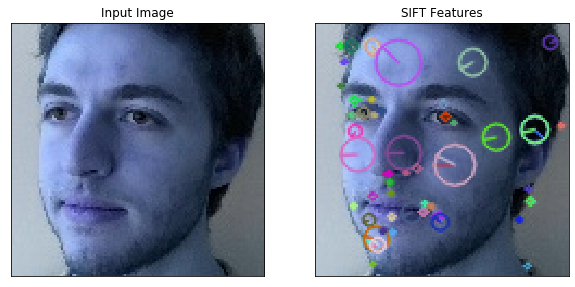

Num keypoints: 64
count=  6
(15, 15, 15, 3)


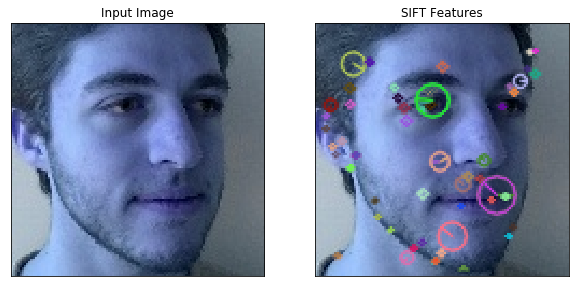

Num keypoints: 64
count=  9
(15, 15, 15, 3)


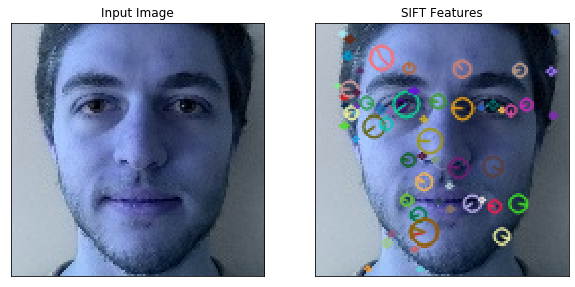

Num keypoints: 70
count=  6
(15, 15, 15, 3)


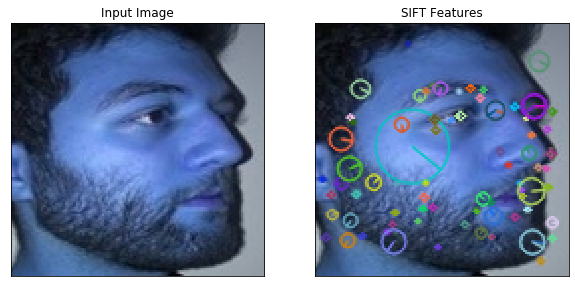

Num keypoints: 88
count=  6
(15, 15, 15, 3)


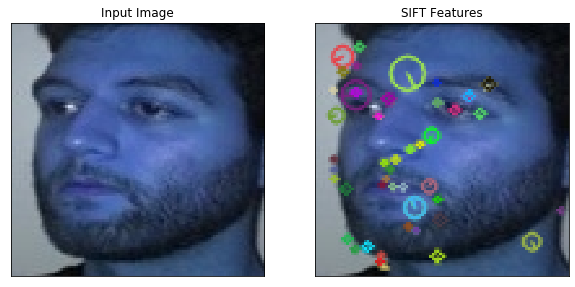

Num keypoints: 54
count=  12
(15, 15, 15, 3)


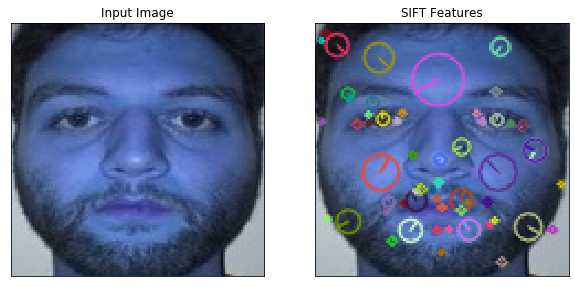

Num keypoints: 68
count=  7
(15, 15, 15, 3)


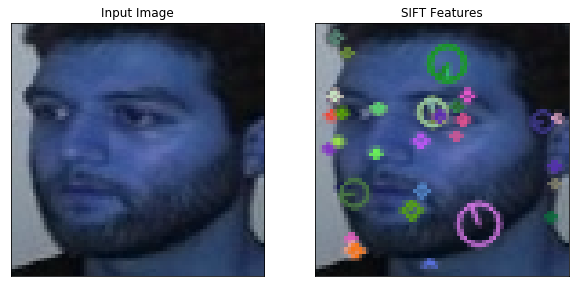

Num keypoints: 38
count=  13
(15, 15, 15, 3)


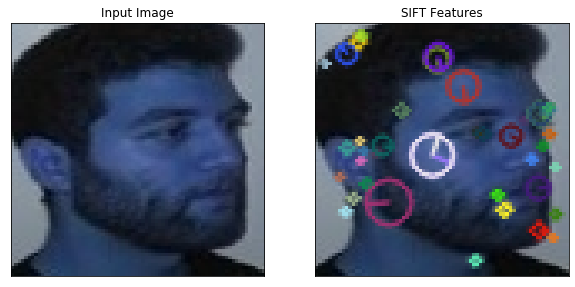

Num keypoints: 40
count=  11
(15, 15, 15, 3)


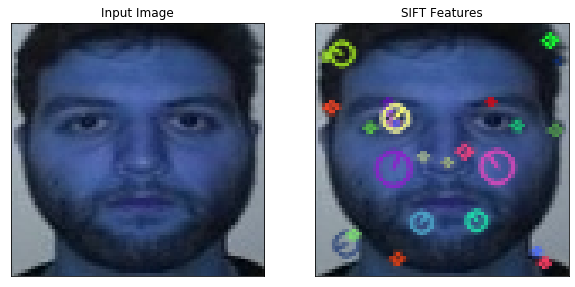

Num keypoints: 28
count=  6
(15, 15, 15, 3)


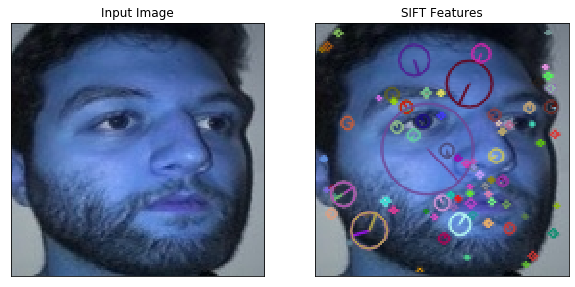

Num keypoints: 99
count=  11
(15, 15, 15, 3)


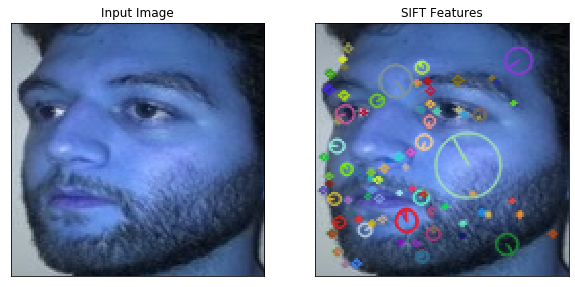

Num keypoints: 93
count=  15
(15, 15, 15, 3)


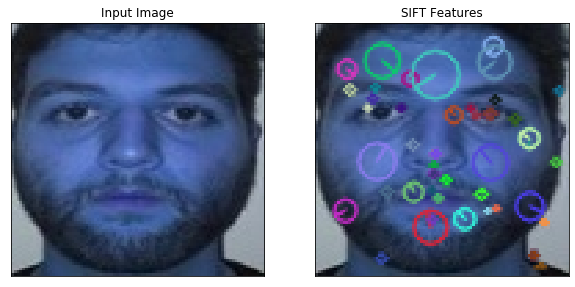

Num keypoints: 50
count=  5
(15, 15, 15, 3)


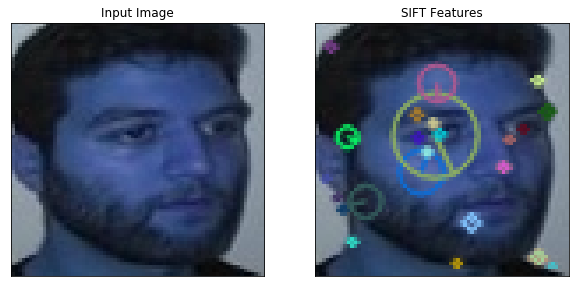

Num keypoints: 28
count=  7
(15, 15, 15, 3)


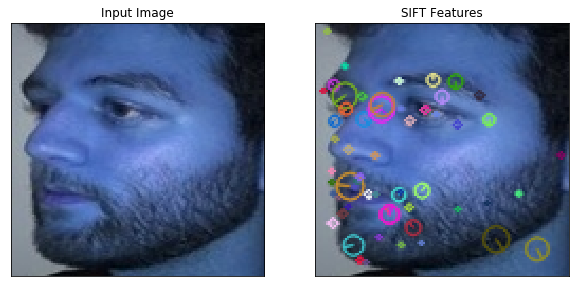

Num keypoints: 62
count=  14
(15, 15, 15, 3)


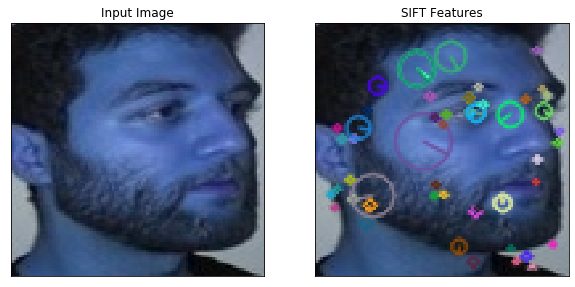

Num keypoints: 56
count=  8
(15, 15, 15, 3)


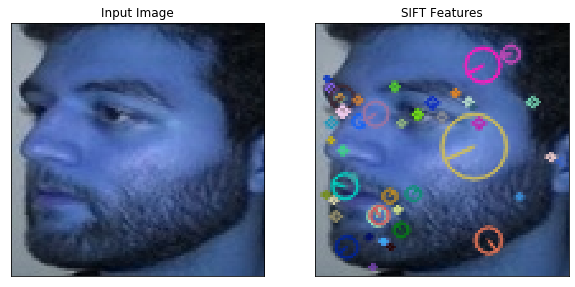

Num keypoints: 51
count=  15
(15, 15, 15, 3)


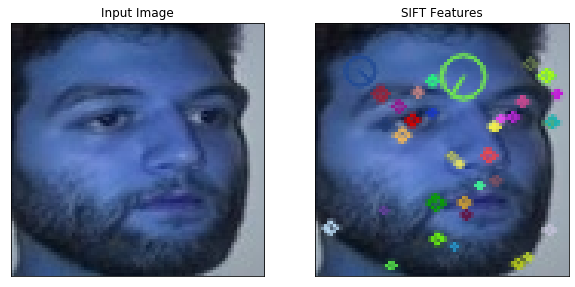

Num keypoints: 40
count=  4
(15, 15, 15, 3)


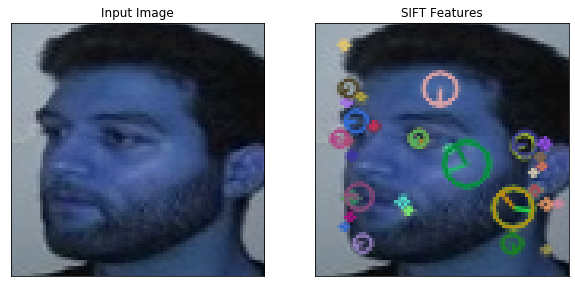

Num keypoints: 42
count=  14
(15, 15, 15, 3)


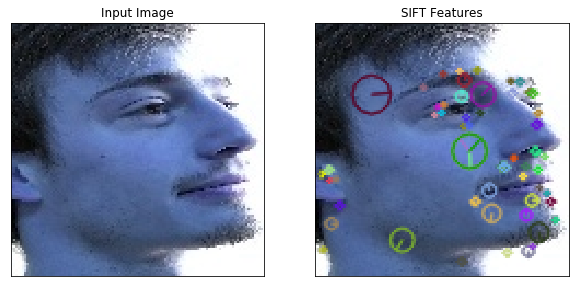

Num keypoints: 60
count=  8
(15, 15, 15, 3)


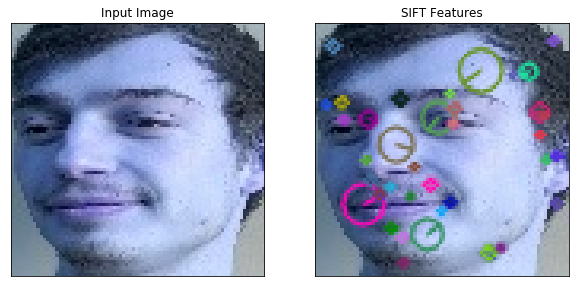

Num keypoints: 46
count=  5
(15, 15, 15, 3)


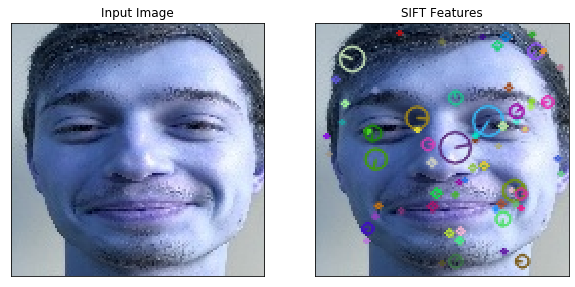

Num keypoints: 75
count=  6
(15, 15, 15, 3)


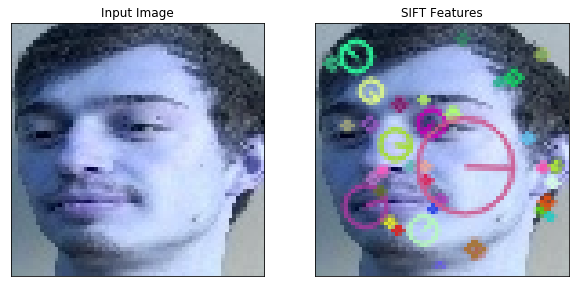

Num keypoints: 41
count=  9
(15, 15, 15, 3)


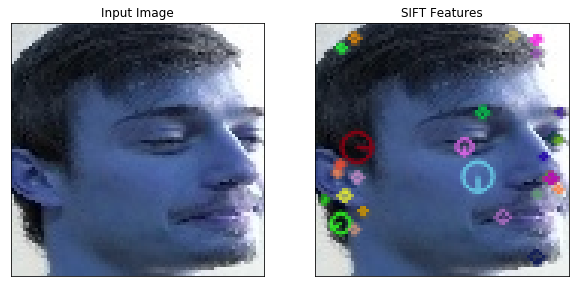

Num keypoints: 29
count=  10
(15, 15, 15, 3)


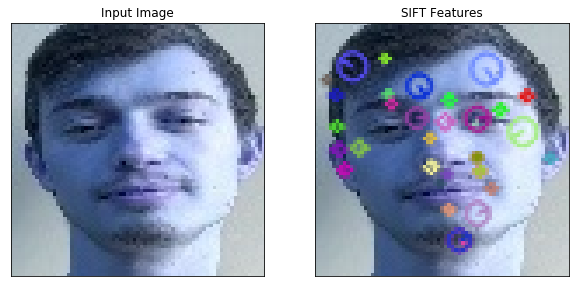

Num keypoints: 34
count=  8
(15, 15, 15, 3)


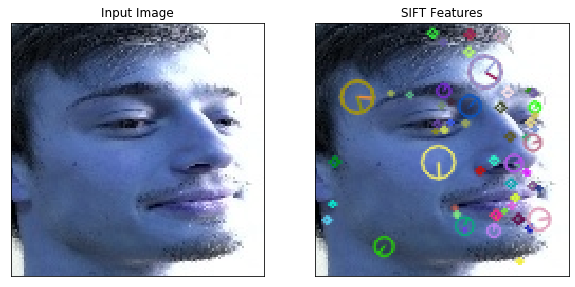

Num keypoints: 65
count=  7
(15, 15, 15, 3)


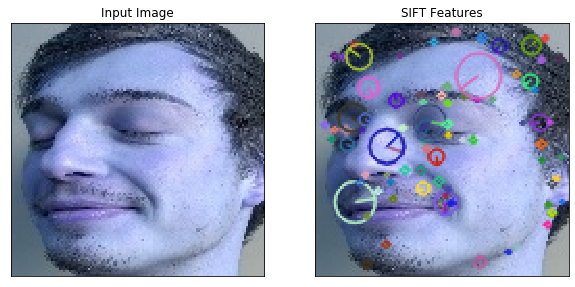

Num keypoints: 94
count=  7
(15, 15, 15, 3)


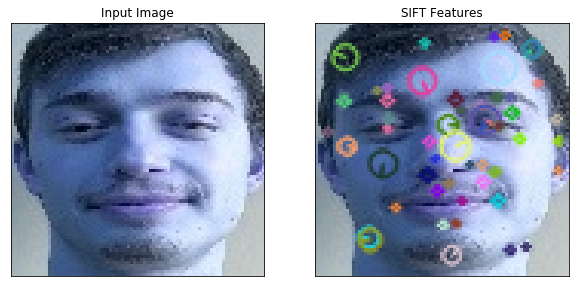

Num keypoints: 55
count=  7
(15, 15, 15, 3)


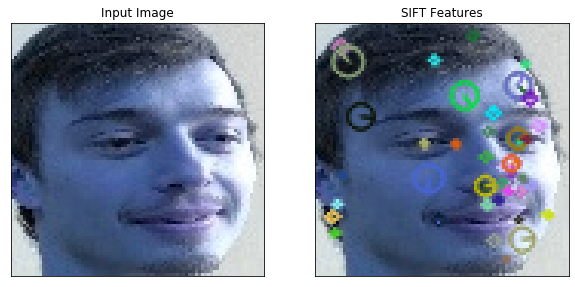

Num keypoints: 47
count=  9
(15, 15, 15, 3)


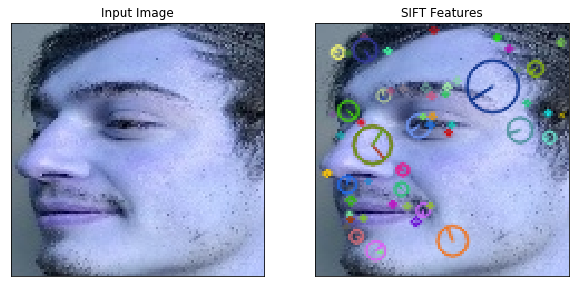

Num keypoints: 57
count=  10
(15, 15, 15, 3)


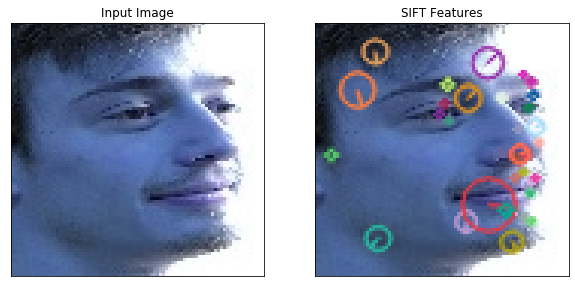

Num keypoints: 35
count=  5
(15, 15, 15, 3)


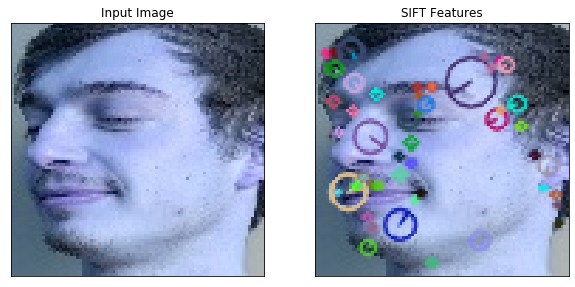

Num keypoints: 60
count=  15
(15, 15, 15, 3)


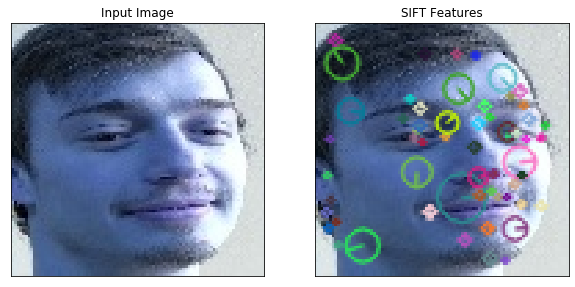

Num keypoints: 61
count=  11
(15, 15, 15, 3)


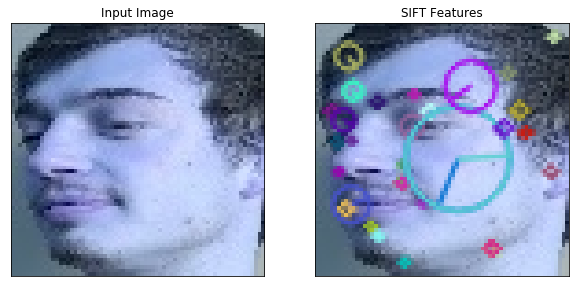

Num keypoints: 32
count=  11
(15, 15, 15, 3)


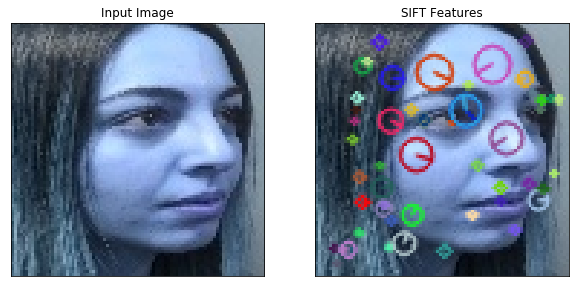

Num keypoints: 53
count=  12
(15, 15, 15, 3)


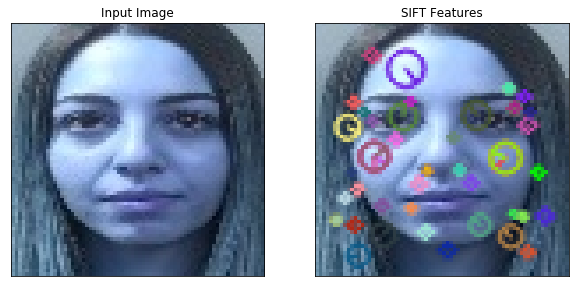

Num keypoints: 50
count=  11
(15, 15, 15, 3)


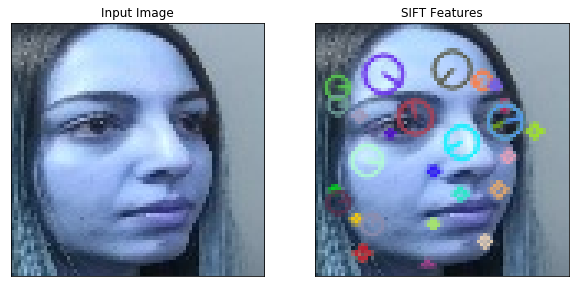

Num keypoints: 32
count=  8
(15, 15, 15, 3)


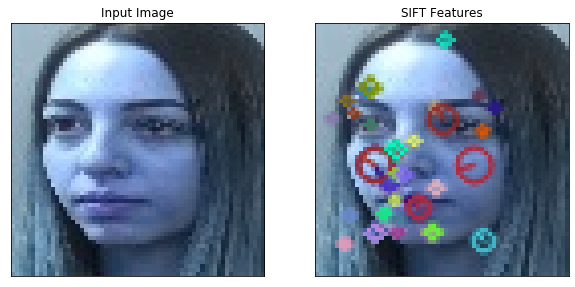

Num keypoints: 43
count=  15
(15, 15, 15, 3)


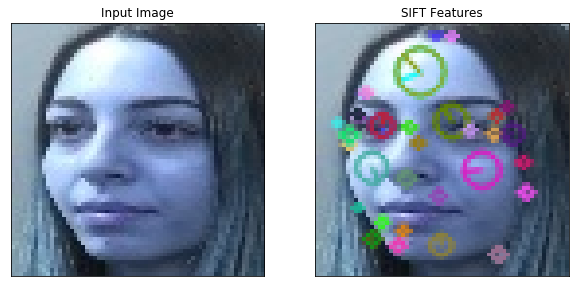

Num keypoints: 38
count=  13
(15, 15, 15, 3)


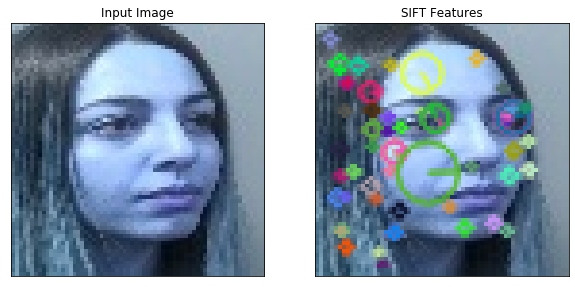

Num keypoints: 60
count=  15
(15, 15, 15, 3)


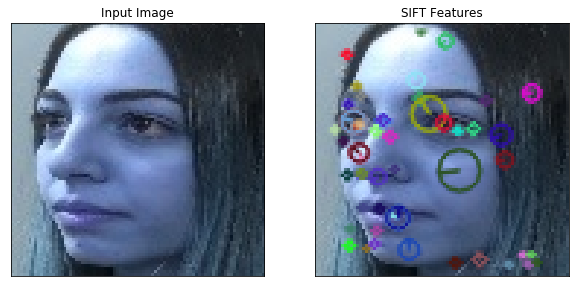

Num keypoints: 51
count=  13
(15, 15, 15, 3)


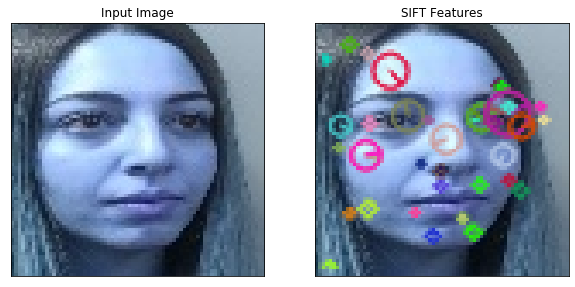

Num keypoints: 43
count=  11
(15, 15, 15, 3)


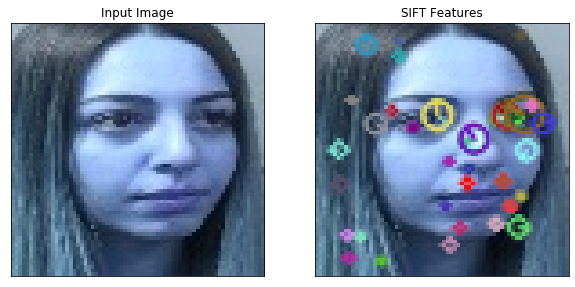

Num keypoints: 42
count=  11
(15, 15, 15, 3)


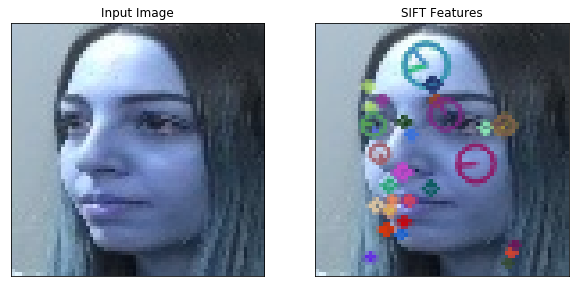

Num keypoints: 36
count=  4
(15, 15, 15, 3)


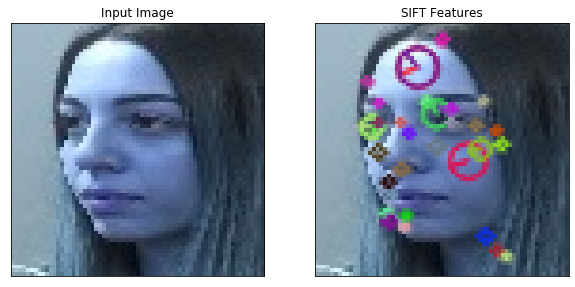

Num keypoints: 34
count=  5
(15, 15, 15, 3)


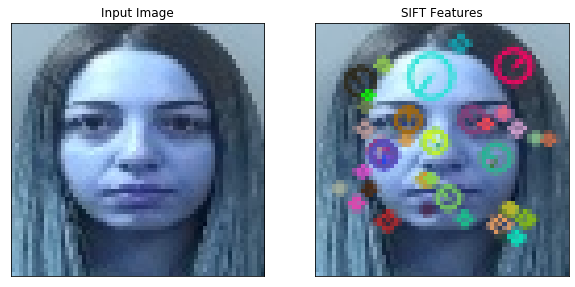

Num keypoints: 48
count=  10
(15, 15, 15, 3)


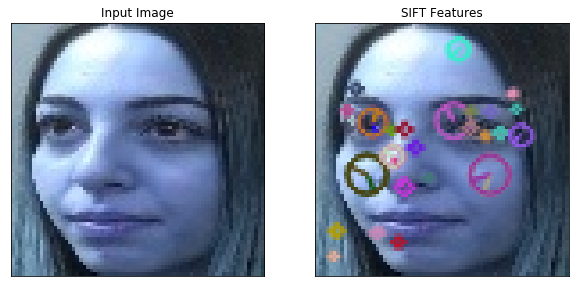

Num keypoints: 32
count=  10
(15, 15, 15, 3)


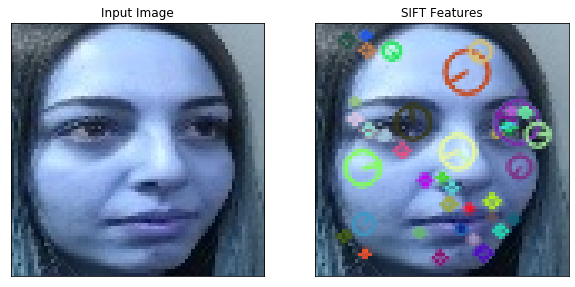

Num keypoints: 45
count=  10
(15, 15, 15, 3)


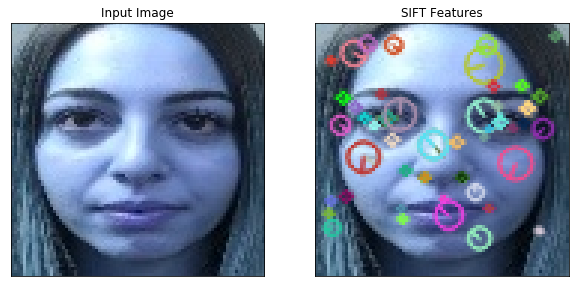

Num keypoints: 58
count=  10
(15, 15, 15, 3)


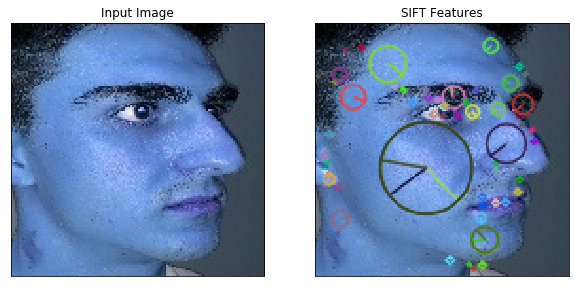

Num keypoints: 64
count=  13
(15, 15, 15, 3)


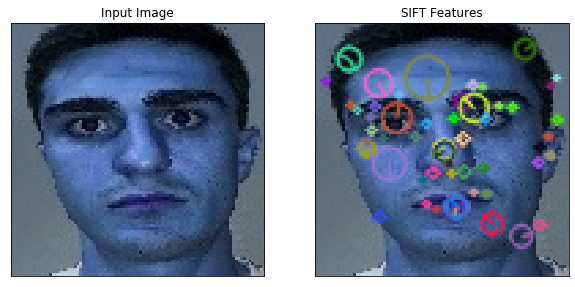

Num keypoints: 57
count=  4
(15, 15, 15, 3)


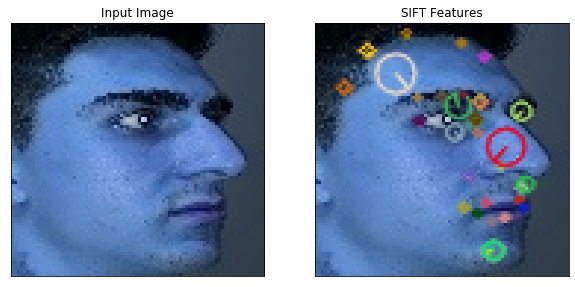

Num keypoints: 35
count=  4
(15, 15, 15, 3)


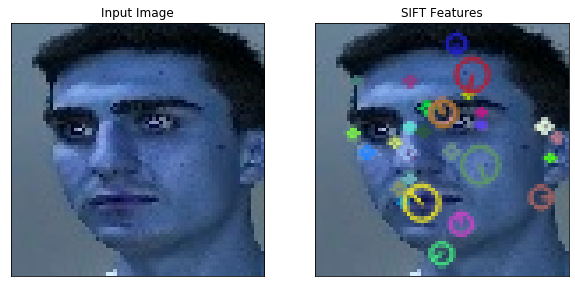

Num keypoints: 33
count=  3
(15, 15, 15, 3)


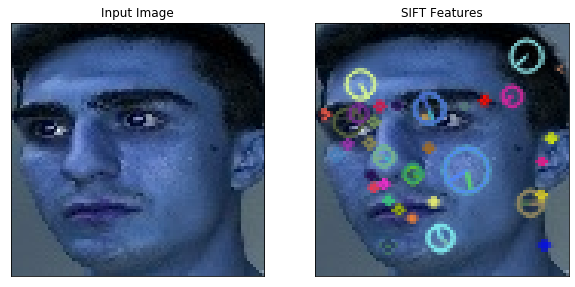

Num keypoints: 43
count=  7
(15, 15, 15, 3)


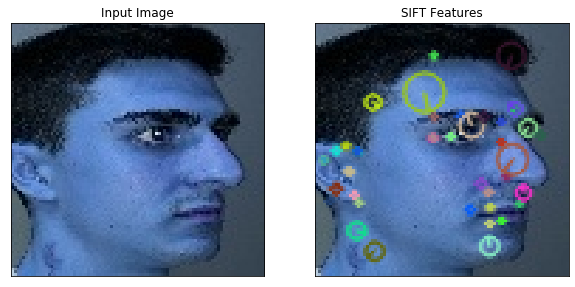

Num keypoints: 44
count=  12
(15, 15, 15, 3)


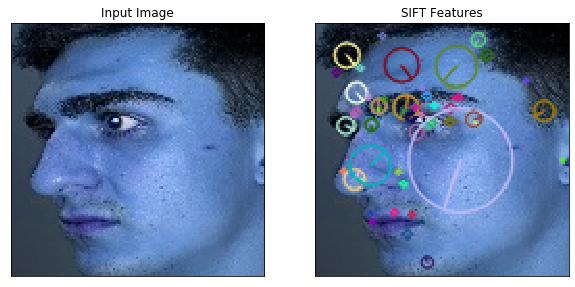

Num keypoints: 59
count=  6
(15, 15, 15, 3)


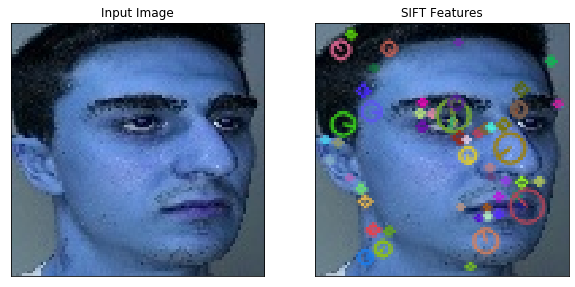

Num keypoints: 57
count=  9
(15, 15, 15, 3)


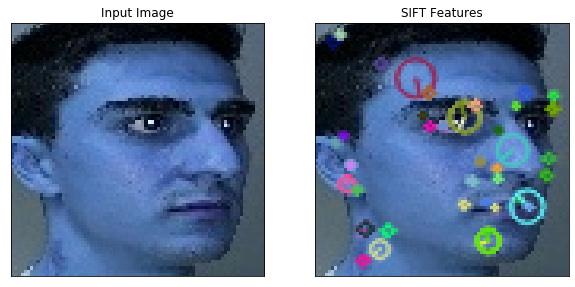

Num keypoints: 47
count=  12
(15, 15, 15, 3)


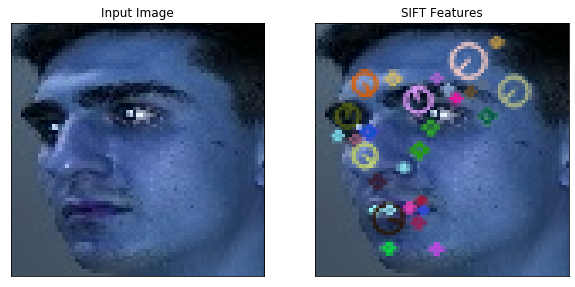

Num keypoints: 34
count=  6
(15, 15, 15, 3)


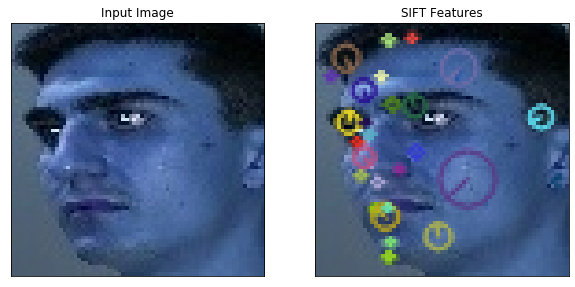

Num keypoints: 29
count=  11
(15, 15, 15, 3)


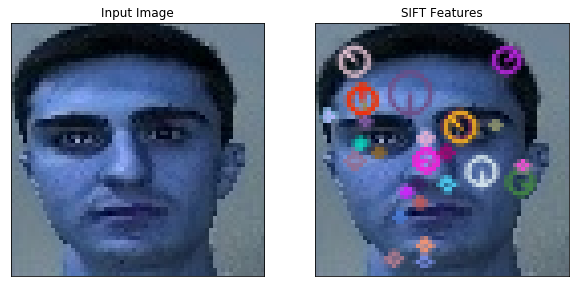

Num keypoints: 30
count=  9
(15, 15, 15, 3)


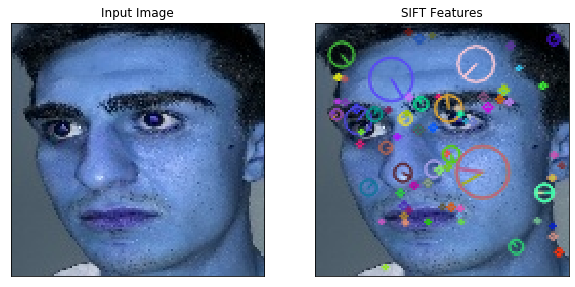

Num keypoints: 86
count=  9
(15, 15, 15, 3)


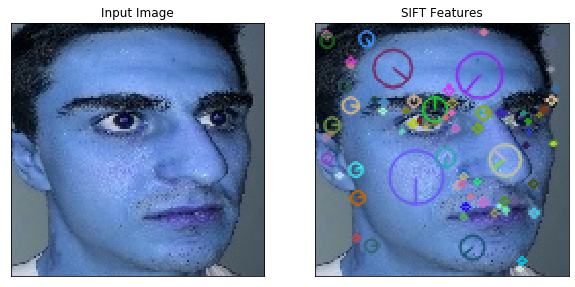

Num keypoints: 82
count=  9
(15, 15, 15, 3)


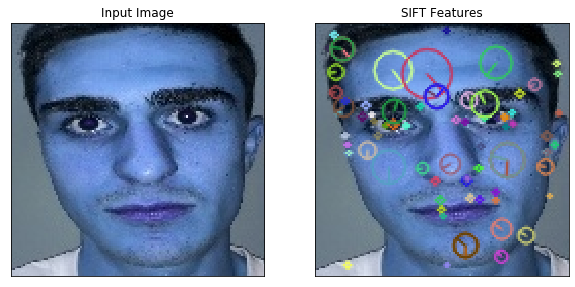

Num keypoints: 80
count=  11
(15, 15, 15, 3)
#########################################################


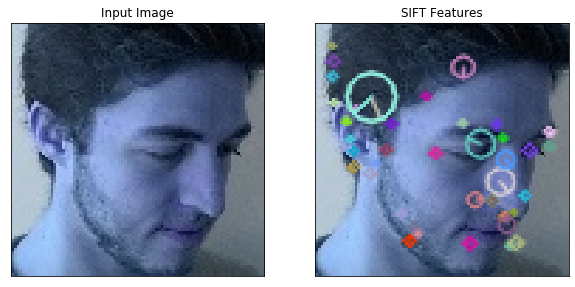

Num keypoints: 45
count=  10
(15, 15, 15, 3)


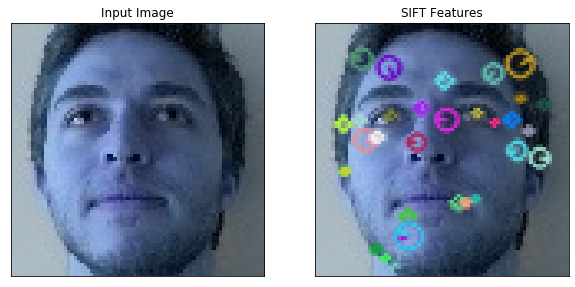

Num keypoints: 33
count=  12
(15, 15, 15, 3)


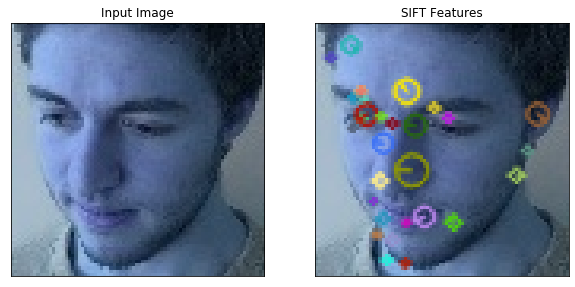

Num keypoints: 34
count=  9
(15, 15, 15, 3)


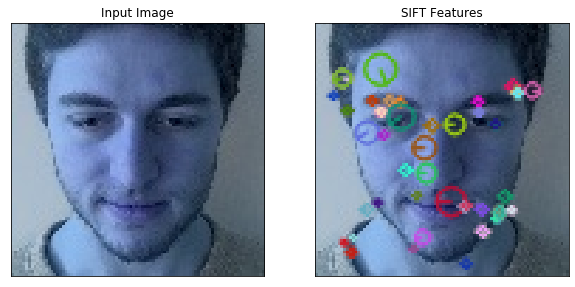

Num keypoints: 51
count=  9
(15, 15, 15, 3)


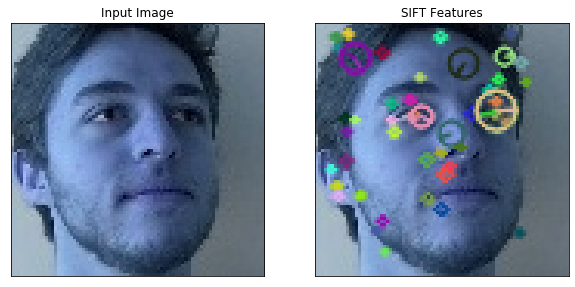

Num keypoints: 58
count=  15
(15, 15, 15, 3)


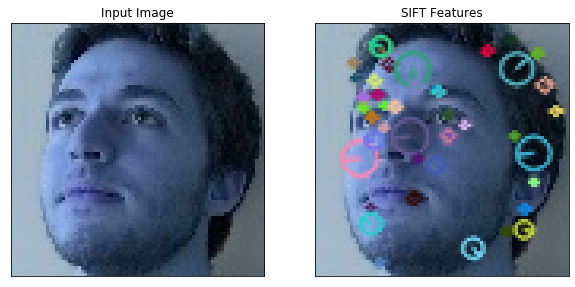

Num keypoints: 46
count=  8
(15, 15, 15, 3)


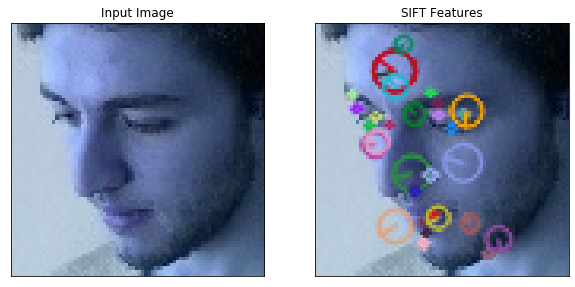

Num keypoints: 33
count=  6
(15, 15, 15, 3)


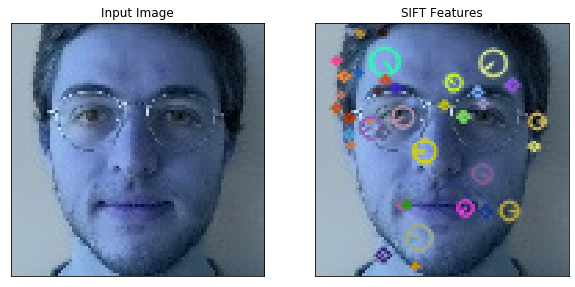

Num keypoints: 45
count=  10
(15, 15, 15, 3)


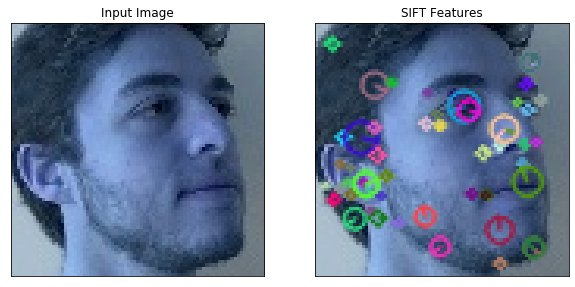

Num keypoints: 61
count=  13
(15, 15, 15, 3)


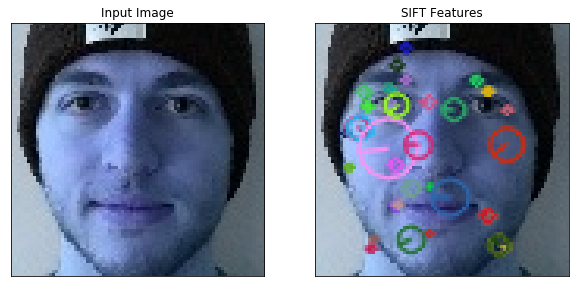

Num keypoints: 39
count=  6
(15, 15, 15, 3)


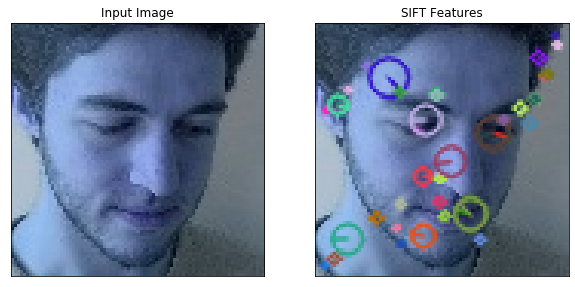

Num keypoints: 41
count=  9
(15, 15, 15, 3)


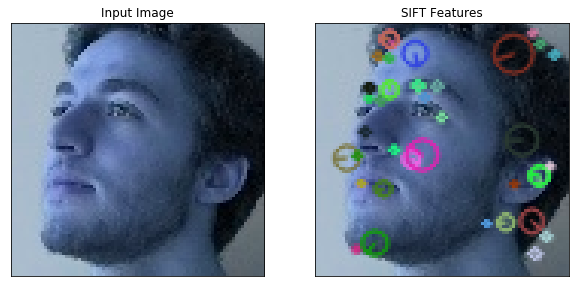

Num keypoints: 40
count=  8
(15, 15, 15, 3)


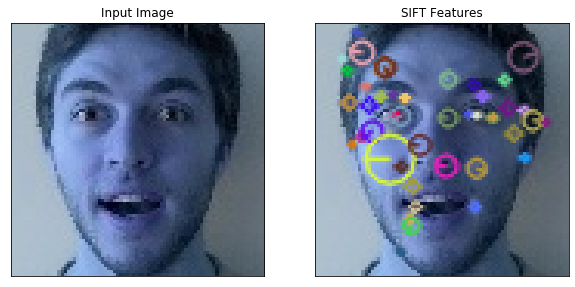

Num keypoints: 48
count=  10
(15, 15, 15, 3)


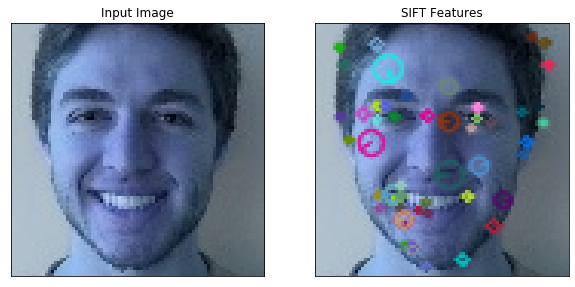

Num keypoints: 55
count=  7
(15, 15, 15, 3)


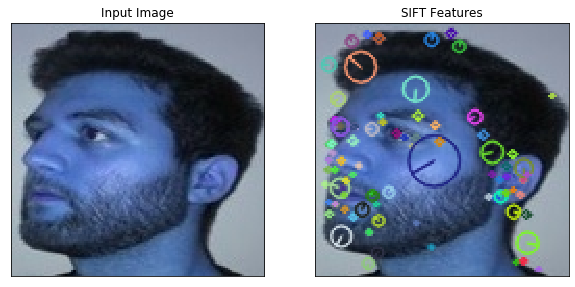

Num keypoints: 92
count=  15
(15, 15, 15, 3)


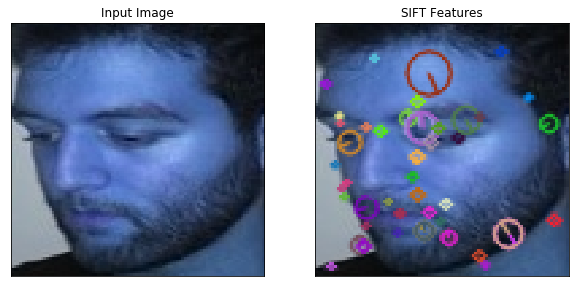

Num keypoints: 51
count=  12
(15, 15, 15, 3)


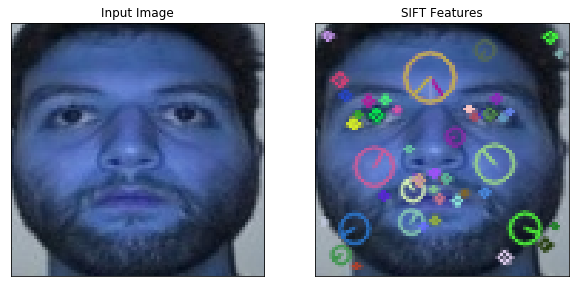

Num keypoints: 55
count=  10
(15, 15, 15, 3)


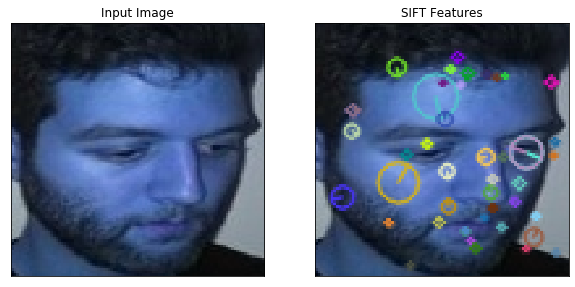

Num keypoints: 48
count=  5
(15, 15, 15, 3)


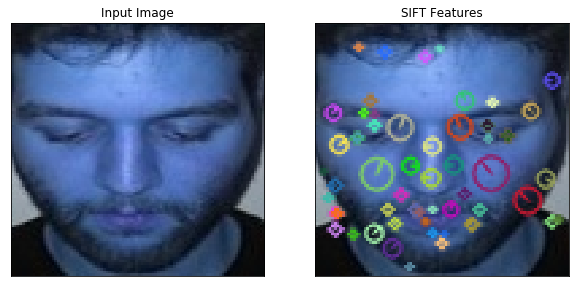

Num keypoints: 60
count=  10
(15, 15, 15, 3)


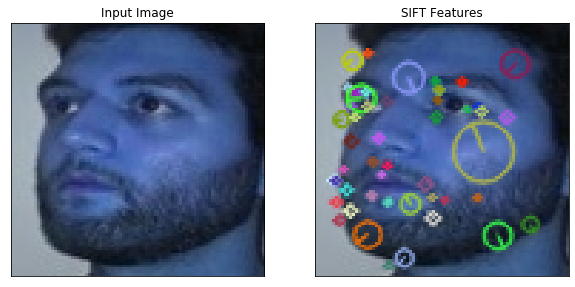

Num keypoints: 55
count=  15
(15, 15, 15, 3)


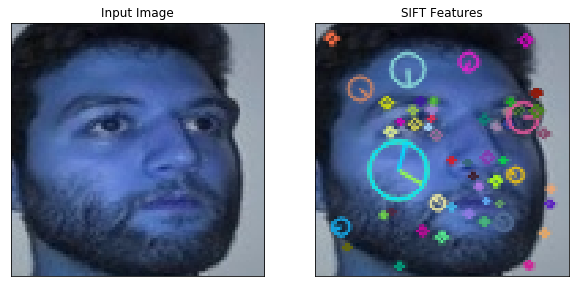

Num keypoints: 66
count=  4
(15, 15, 15, 3)


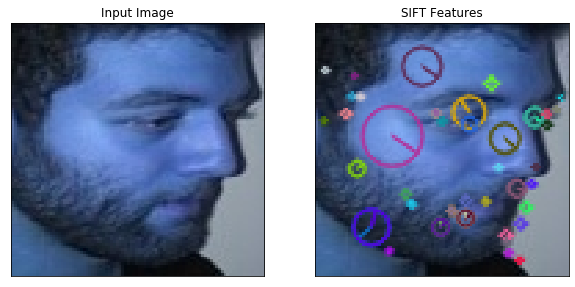

Num keypoints: 47
count=  7
(15, 15, 15, 3)


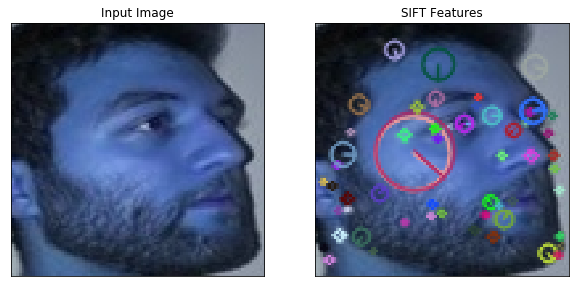

Num keypoints: 61
count=  12
(15, 15, 15, 3)


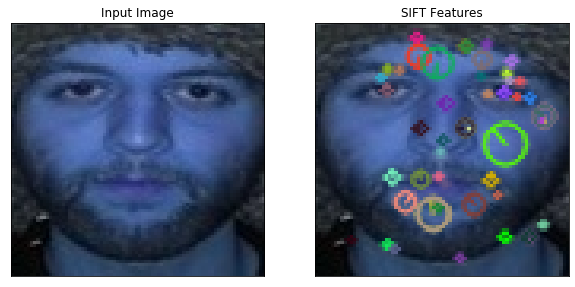

Num keypoints: 50
count=  7
(15, 15, 15, 3)


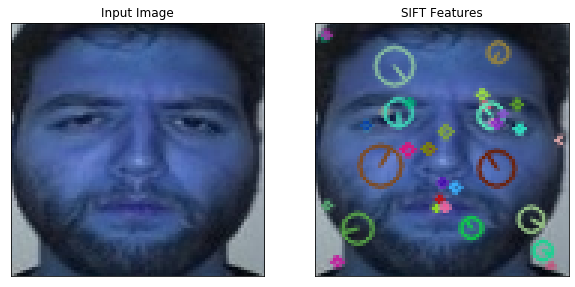

Num keypoints: 40
count=  6
(15, 15, 15, 3)


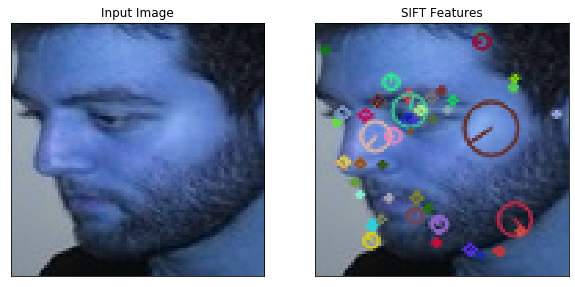

Num keypoints: 48
count=  7
(15, 15, 15, 3)


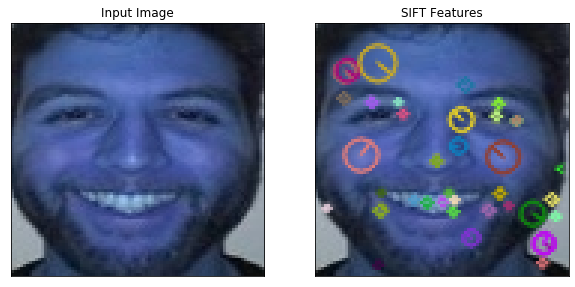

Num keypoints: 41
count=  7
(15, 15, 15, 3)


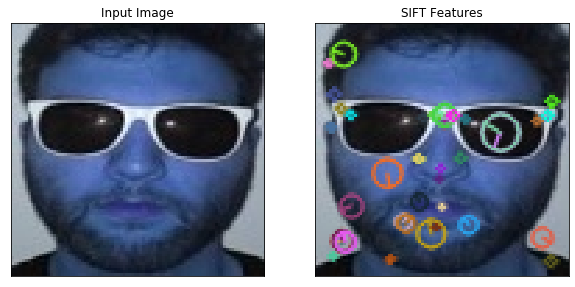

Num keypoints: 43
count=  14
(15, 15, 15, 3)


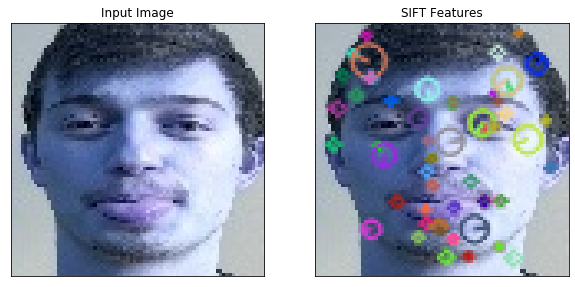

Num keypoints: 60
count=  8
(15, 15, 15, 3)


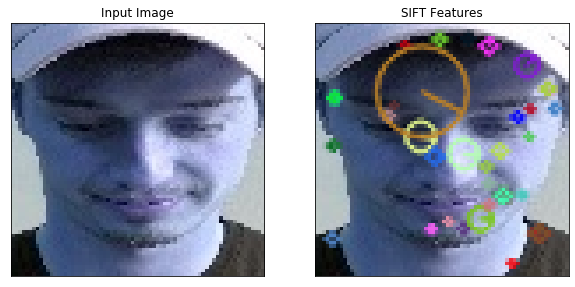

Num keypoints: 38
count=  9
(15, 15, 15, 3)


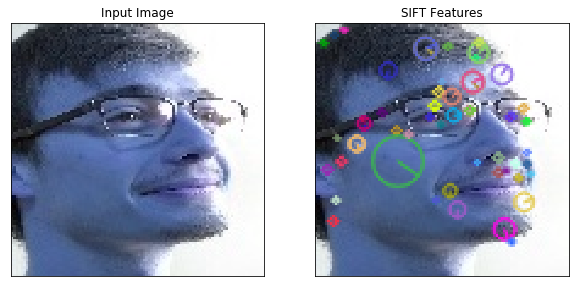

Num keypoints: 58
count=  8
(15, 15, 15, 3)


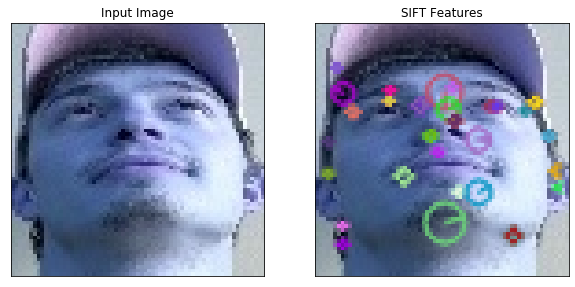

Num keypoints: 40
count=  7
(15, 15, 15, 3)


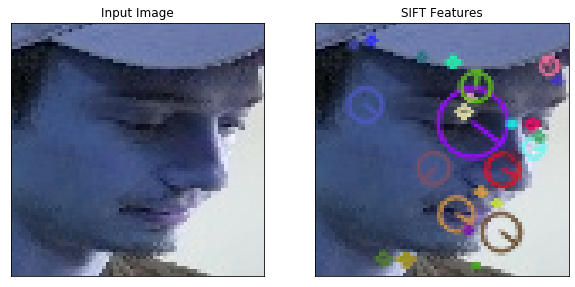

Num keypoints: 28
count=  10
(15, 15, 15, 3)


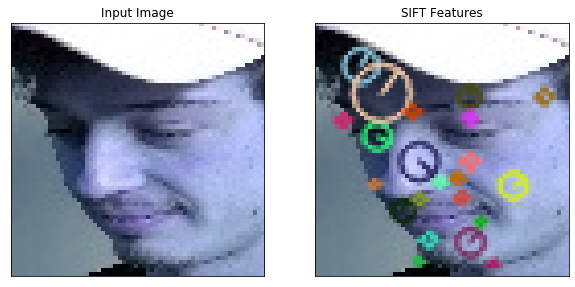

Num keypoints: 24
count=  6
(15, 15, 15, 3)


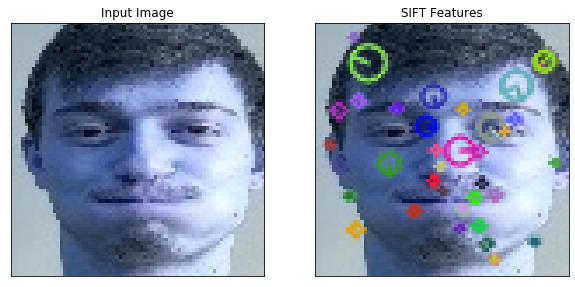

Num keypoints: 44
count=  9
(15, 15, 15, 3)


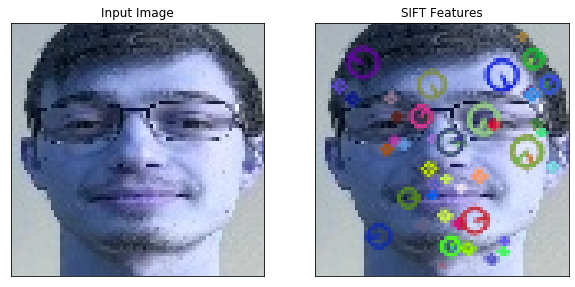

Num keypoints: 53
count=  4
(15, 15, 15, 3)


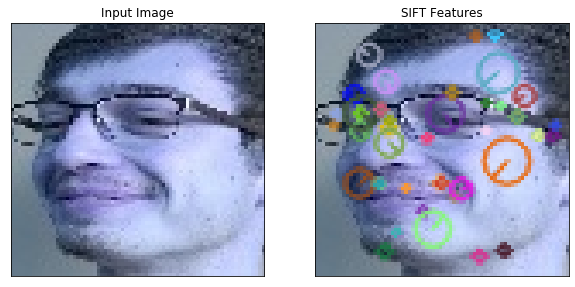

Num keypoints: 48
count=  10
(15, 15, 15, 3)


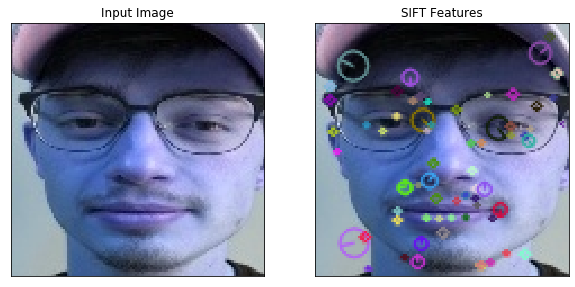

Num keypoints: 72
count=  7
(15, 15, 15, 3)


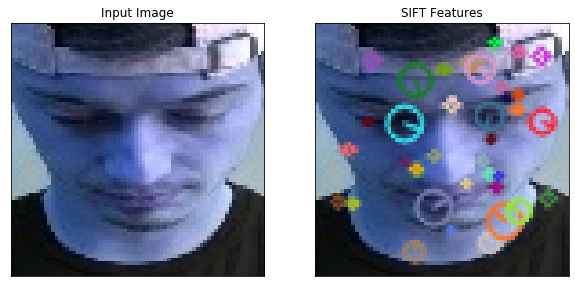

Num keypoints: 40
count=  8
(15, 15, 15, 3)


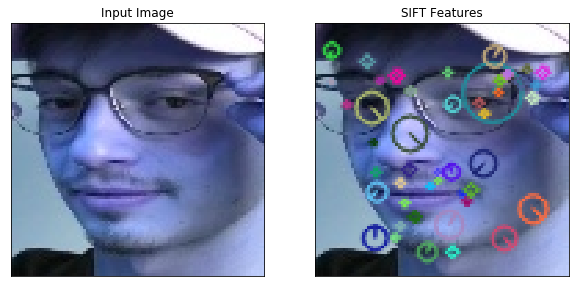

Num keypoints: 53
count=  7
(15, 15, 15, 3)


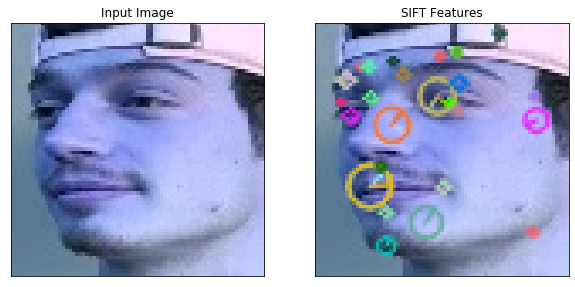

Num keypoints: 32
count=  8
(15, 15, 15, 3)


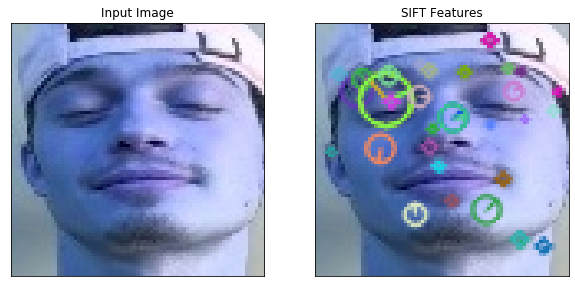

Num keypoints: 36
count=  7
(15, 15, 15, 3)


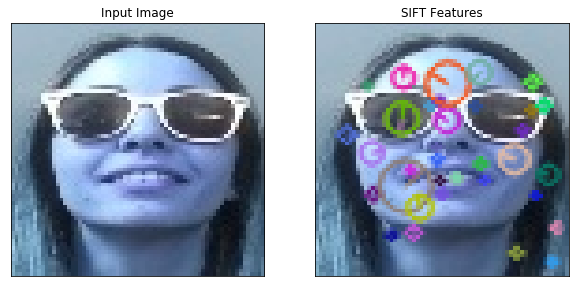

Num keypoints: 39
count=  6
(15, 15, 15, 3)


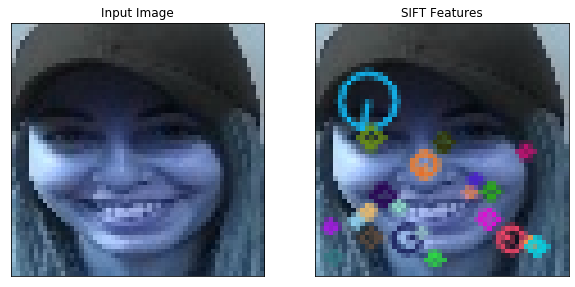

Num keypoints: 25
count=  11
(15, 15, 15, 3)


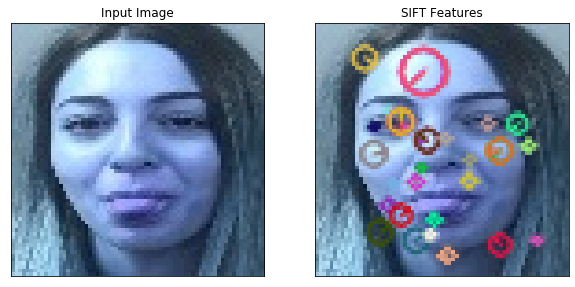

Num keypoints: 35
count=  4
(15, 15, 15, 3)


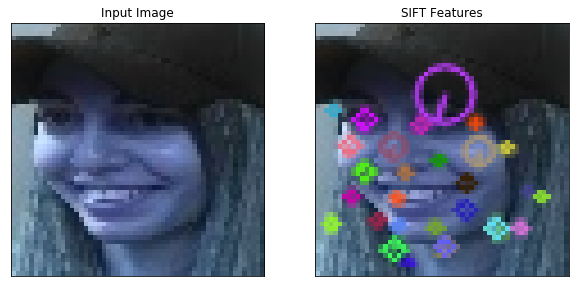

Num keypoints: 30
count=  10
(15, 15, 15, 3)


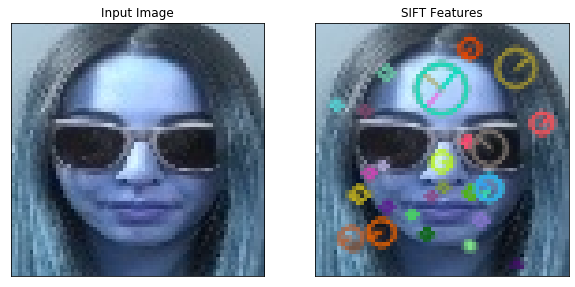

Num keypoints: 31
count=  10
(15, 15, 15, 3)


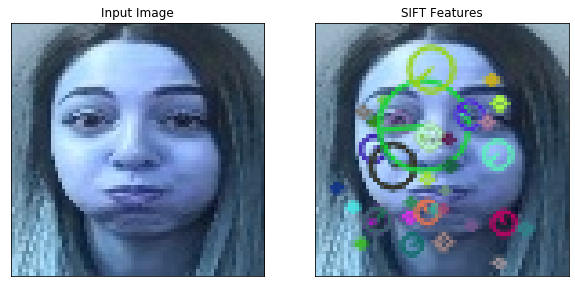

Num keypoints: 42
count=  5
(15, 15, 15, 3)


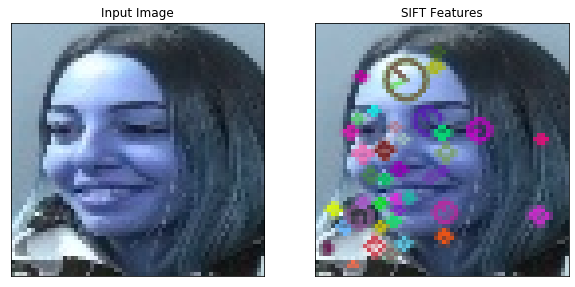

Num keypoints: 50
count=  15
(15, 15, 15, 3)


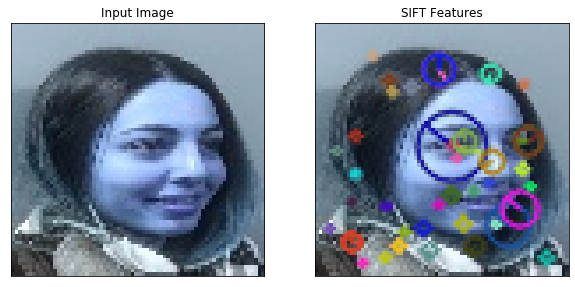

Num keypoints: 45
count=  12
(15, 15, 15, 3)


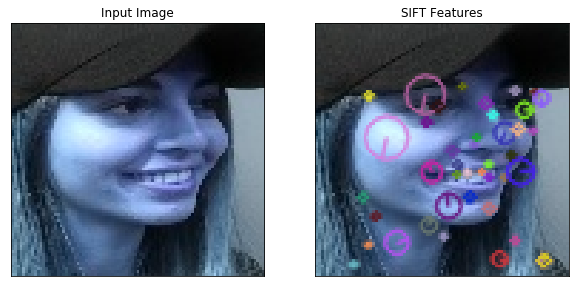

Num keypoints: 45
count=  4
(15, 15, 15, 3)


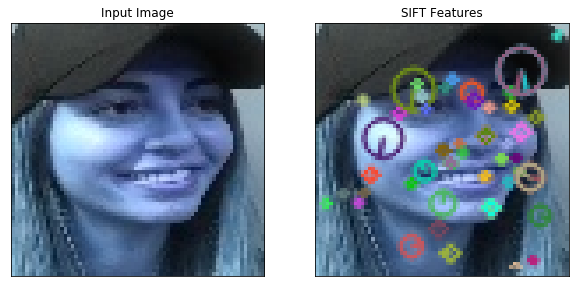

Num keypoints: 51
count=  6
(15, 15, 15, 3)


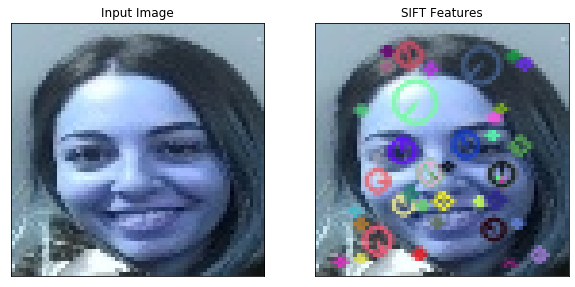

Num keypoints: 46
count=  11
(15, 15, 15, 3)


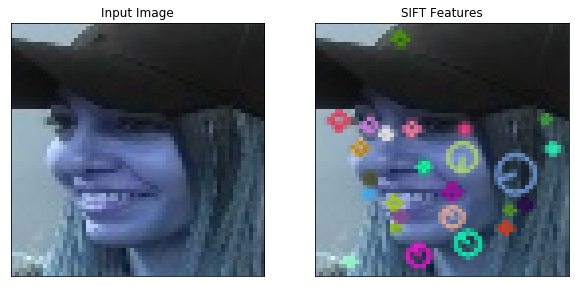

Num keypoints: 27
count=  9
(15, 15, 15, 3)


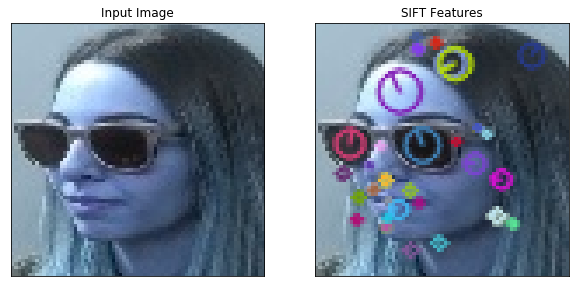

Num keypoints: 36
count=  7
(15, 15, 15, 3)


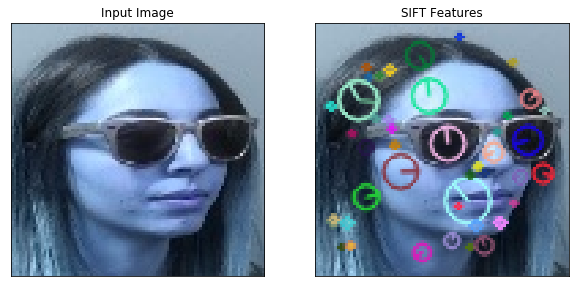

Num keypoints: 53
count=  9
(15, 15, 15, 3)


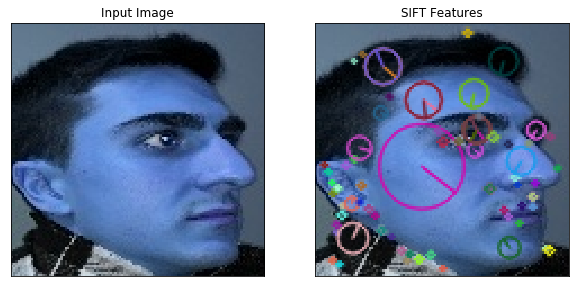

Num keypoints: 75
count=  15
(15, 15, 15, 3)


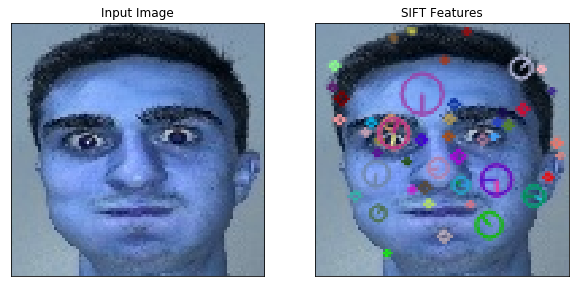

Num keypoints: 53
count=  8
(15, 15, 15, 3)


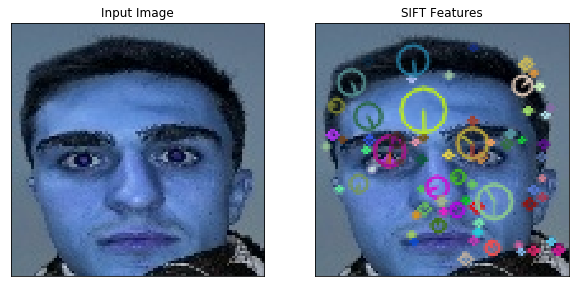

Num keypoints: 80
count=  7
(15, 15, 15, 3)


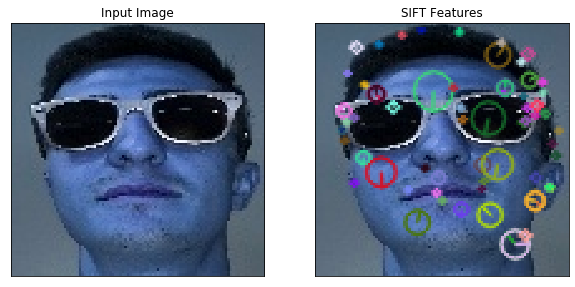

Num keypoints: 64
count=  8
(15, 15, 15, 3)


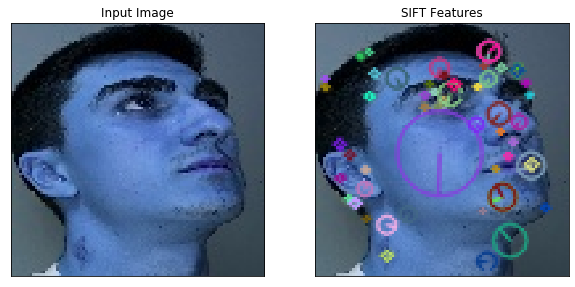

Num keypoints: 61
count=  10
(15, 15, 15, 3)


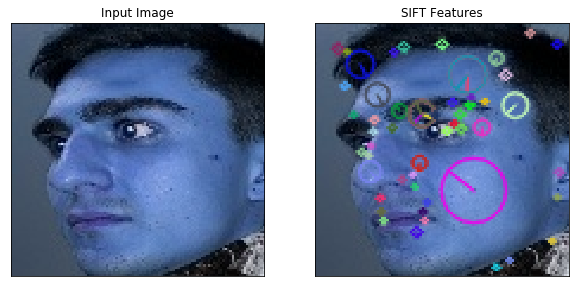

Num keypoints: 58
count=  3
(15, 15, 15, 3)


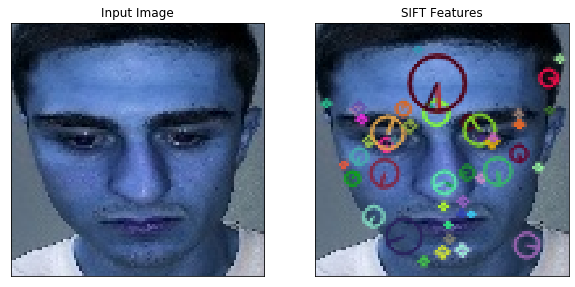

Num keypoints: 49
count=  3
(15, 15, 15, 3)


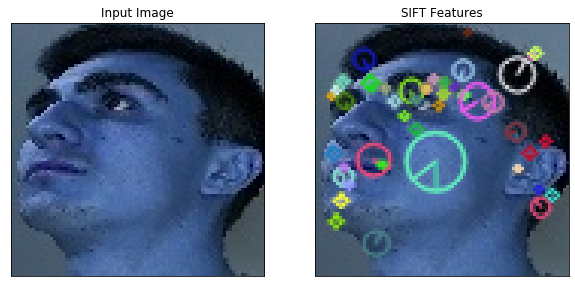

Num keypoints: 54
count=  13
(15, 15, 15, 3)


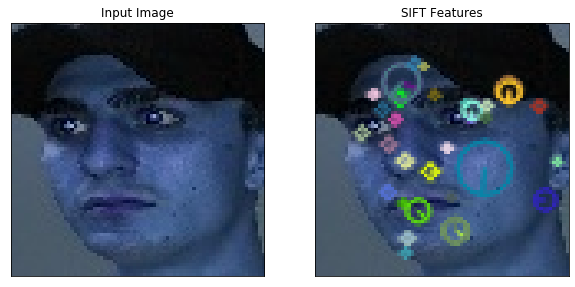

Num keypoints: 34
count=  5
(15, 15, 15, 3)


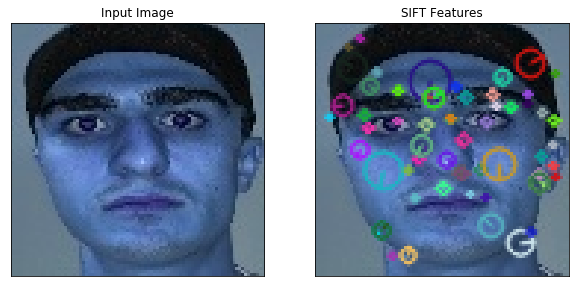

Num keypoints: 68
count=  7
(15, 15, 15, 3)


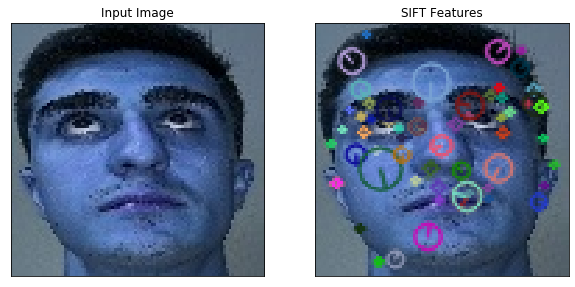

Num keypoints: 65
count=  9
(15, 15, 15, 3)


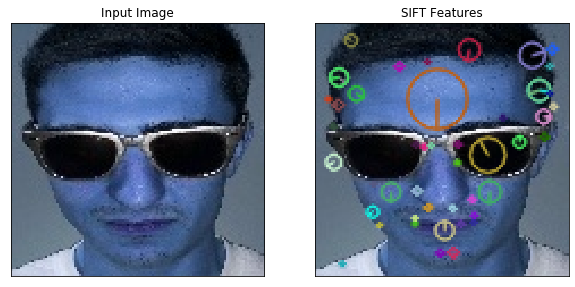

Num keypoints: 48
count=  8
(15, 15, 15, 3)


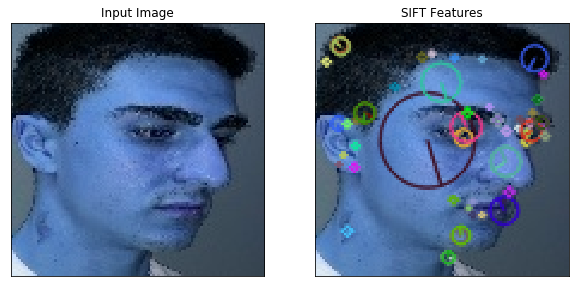

Num keypoints: 62
count=  8
(15, 15, 15, 3)


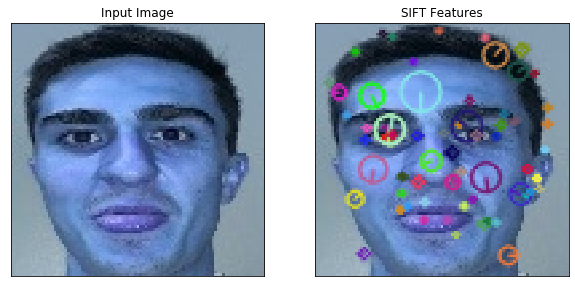

Num keypoints: 72
count=  7
(15, 15, 15, 3)


In [125]:
# Train Images
patches_train_list = []
# min_kp = np.inf
for i in range(0, len(X_train_cropped)):
    cropped_img = X_train_cropped[i]
    original_img = X_train[i]
    kp = sift(cropped_img)
    patches_train = make_patch(img=original_img,img_cropped=cropped_img, size=15, k=kp[:15])
    print(np.shape(patches_train))
    patches_train_list.append(patches_train)


print("#########################################################")
 
# Test Images
patches_test_list = []
for i in range(0, len(X_test_cropped)):  
    cropped_img_test = X_test_cropped[i]
    original_img_test = X_test[i]
    kp = sift(cropped_img_test)
    patches_test = make_patch(img=original_img_test,img_cropped=cropped_img_test, size=15, k=kp[:15])
    print(np.shape(patches_test))
    patches_test_list.append(patches_test)



In [126]:
print('patches_train_list : ', np.shape(patches_train_list))

print('patches_test_list : ', np.shape(patches_test_list))

patches_train_list :  (75, 15, 15, 15, 3)
patches_test_list :  (70, 15, 15, 15, 3)


In [107]:
'''
Extract HoG descriptor for the patch as follows.
Fix the block size= 2, number of bins = 9 and vary the cell size. 
Use cell sizes 3 × 3, 4 × 4 and 5 × 5 . 
------------------------------------------------------
Build separate vocabularies for HoG descriptor with different cell sizes. 

• Cluster feature descriptors into K clusters using Gaussian Mixture Model.
Each cluster center represents one word.
• Compute normalized histogram of words for each training image using Bag of Words (BoW) method. Store the computed histograms. 
Display the histograms for 3 selected images.
--------------------------------------------------------
Test and evaluate the vocabularies using recognition rate. 

• Compute normalized histogram of words for each test image using the
method described in Section 1.
• Find one nearest neighbour histogram from the training set. 
Assign the face identity of the nearest histogram to the test image.
----------------------------------------------------------
Plot recognition rate (on y-axis) vs cell size of the HoG descriptor (on x-axis). 
Compute confusion matrix for the best performing vocabulary.
'''
from sklearn.mixture import GaussianMixture
import matplotlib as mpl

def make_ellipses(gmm, ax):
    K = gmm.means_.shape[0]
    for n in range(K):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color='black')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)




In [127]:
 hog_3_train = []
for patch in patches_train_list:
    hog_ft = hog_features(patch, 3)
    hog_3_train.append(hog_ft)

print(np.shape(hog_3_train))
# hog_3_train =  hog_features(patches_train_list, 3)
# hog_4_train =  hog_features(patches_train_list, 4)
# hog_5_train =  hog_features(patches_train_list, 5)

# Get hog features for all patches of test images for different cell size
# hog_3_test =  hog_features(patches_test_list, 3)
# hog_4_test =  hog_features(patches_test_list, 4)
# hog_5_test =  hog_features(patches_test_list, 5)




(15, 15, 15, 3)
(1, 2025)
(2, 2025)
(3, 2025)
(4, 2025)
(5, 2025)
(6, 2025)
(7, 2025)
(8, 2025)
(9, 2025)
(10, 2025)
(11, 2025)
(12, 2025)
(13, 2025)
(14, 2025)
(15, 2025)
(15, 15, 15, 3)
(1, 2025)
(2, 2025)
(3, 2025)
(4, 2025)
(5, 2025)
(6, 2025)
(7, 2025)
(8, 2025)
(9, 2025)
(10, 2025)
(11, 2025)
(12, 2025)
(13, 2025)
(14, 2025)
(15, 2025)
(15, 15, 15, 3)
(1, 2025)
(2, 2025)
(3, 2025)
(4, 2025)
(5, 2025)
(6, 2025)
(7, 2025)
(8, 2025)
(9, 2025)
(10, 2025)
(11, 2025)
(12, 2025)
(13, 2025)
(14, 2025)
(15, 2025)
(15, 15, 15, 3)
(1, 2025)
(2, 2025)
(3, 2025)
(4, 2025)
(5, 2025)
(6, 2025)
(7, 2025)
(8, 2025)
(9, 2025)
(10, 2025)
(11, 2025)
(12, 2025)
(13, 2025)
(14, 2025)
(15, 2025)
(15, 15, 15, 3)
(1, 2025)
(2, 2025)
(3, 2025)
(4, 2025)
(5, 2025)
(6, 2025)
(7, 2025)
(8, 2025)
(9, 2025)
(10, 2025)
(11, 2025)
(12, 2025)
(13, 2025)
(14, 2025)
(15, 2025)
(15, 15, 15, 3)
(1, 2025)
(2, 2025)
(3, 2025)
(4, 2025)
(5, 2025)
(6, 2025)
(7, 2025)
(8, 2025)
(9, 2025)
(10, 2025)
(11, 2025)
(12, 2025)
(

(11, 2025)
(12, 2025)
(13, 2025)
(14, 2025)
(15, 2025)
(15, 15, 15, 3)
(1, 2025)
(2, 2025)
(3, 2025)
(4, 2025)
(5, 2025)
(6, 2025)
(7, 2025)
(8, 2025)
(9, 2025)
(10, 2025)
(11, 2025)
(12, 2025)
(13, 2025)
(14, 2025)
(15, 2025)
(15, 15, 15, 3)
(1, 2025)
(2, 2025)
(3, 2025)
(4, 2025)
(5, 2025)
(6, 2025)
(7, 2025)
(8, 2025)
(9, 2025)
(10, 2025)
(11, 2025)
(12, 2025)
(13, 2025)
(14, 2025)
(15, 2025)
(15, 15, 15, 3)
(1, 2025)
(2, 2025)
(3, 2025)
(4, 2025)
(5, 2025)
(6, 2025)
(7, 2025)
(8, 2025)
(9, 2025)
(10, 2025)
(11, 2025)
(12, 2025)
(13, 2025)
(14, 2025)
(15, 2025)
(15, 15, 15, 3)
(1, 2025)
(2, 2025)
(3, 2025)
(4, 2025)
(5, 2025)
(6, 2025)
(7, 2025)
(8, 2025)
(9, 2025)
(10, 2025)
(11, 2025)
(12, 2025)
(13, 2025)
(14, 2025)
(15, 2025)
(15, 15, 15, 3)
(1, 2025)
(2, 2025)
(3, 2025)
(4, 2025)
(5, 2025)
(6, 2025)
(7, 2025)
(8, 2025)
(9, 2025)
(10, 2025)
(11, 2025)
(12, 2025)
(13, 2025)
(14, 2025)
(15, 2025)
(15, 15, 15, 3)
(1, 2025)
(2, 2025)
(3, 2025)
(4, 2025)
(5, 2025)
(6, 2025)
(7, 2025)

In [ ]:
# Gaussian Mixture Model

hog_3_flat = []
for h in hog_3_train:
    print("h" ,np.shape(h))
    hog_3_flat.append(np.asarray(h).flatten().ravel())
    print(np.asarray(h).flatten().ravel().shape)
print(np.shape(hog_3_flat))

hh = np.asarray(hog_3_flat)


print("hh " , hh.shape)


hog_3_train=np.asarray(hog_3_train)

# test_hog = np.reshape(test_hog, (-1, 1))
print(hog_3_train.shape)

gmm = GaussianMixture(n_components=5, covariance_type='full')

gmm.fit(hh)


# the centers of the fitted GMM
centers = gmm.means_

# predict cluster membership from the fitted GMM 
label = gmm.predict(hh)

h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 2025)
(30375,)
h (15, 202

(80, 2025)
(80,)
[2 2 2 2 1 2 2 2 2 1 4 1 1 3 3 1 1 1 1 1 1 1 1 1 1 1 1 0 3 4 1 3 1 1 1 1 1
 3 2 3 2 2 2 2 2 2 3 0 1 3 3 3 1 3 1 4 1 2 2 3 1 1 1 1 0 0 3 3 0 2 1 3 0 3
 3 1 0 1 3 4]
80


Text(0.5, 1.0, 'Train data points - Labeled')

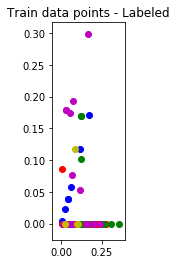

In [83]:
print(hog_3_train.shape)
print(label.shape)
print(label)
print(len(label))

# hog_3_train = np.reshape((1, -1))
#hog_3_train = np.reshape(hog_3_train, (80, 2025))
# np.reshape((2000, 2))


A = hog_3_train[label==0]
B = hog_3_train[label==1]
C = hog_3_train[label==2]
D = hog_3_train[label==3]
E = hog_3_train[label==4]

# plt.figure(figsize=(20,2.5))
# plt.subplot(141)
# plt.plot(test_hog[:,0], test_hog[:,1],"ko")
# plt.title("Train data points")
h = plt.subplot(142)
plt.scatter(A[:,0], A[:,0], color='b')
plt.scatter(B[:,0], B[:,1], color='r')
plt.scatter(C[:,0], C[:,1], color='g')
plt.scatter(D[:,0], D[:,1], color='m')
plt.scatter(E[:,0], E[:,1], color='y')

# make_ellipses(gmm, h)
plt.title("Train data points - Labeled")